In [4]:
!pip install fuzzywuzzy

In [5]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from fuzzywuzzy import process
import sqlite3

# Explore Data

In [6]:
collisions = pd.read_csv('/Users/annaywj/Desktop/SDSU/CS577/pd_collisions_datasd.csv')
traffic = pd.read_csv('/Users/annaywj/Desktop/SDSU/CS577/traffic_counts_datasd.csv')
collisions.head()

,report_id,date_time,police_beat,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,192016,2015-03-19 12:00:00,622,5200,,LINDA VISTA,ROAD,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
1,190012,2015-03-24 03:05:00,626,1000,W,WASHINGTON,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,2,0,NaN
2,191866,2015-03-27 23:56:00,613,2800,,WORDEN,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,1,0,NaN
3,185207,2015-07-06 11:45:00,813,2800,,EL CAJON,BOULEVARD,,,,20002(A),VC,HIT AND RUN,0,0,MISDEMEANOR
4,1608987,2015-08-22 13:45:00,999,0,,DE ANZA POINT,,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,1,0,NaN


In [7]:
collisions.dtypes

report_id                    object
date_time                    object
police_beat                   int64
address_no_primary            int64
address_pd_primary           object
address_road_primary         object
address_sfx_primary          object
address_pd_intersecting      object
address_name_intersecting    object
address_sfx_intersecting     object
violation_section            object
violation_type               object
charge_desc                  object
injured                       int64
killed                        int64
hit_run_lvl                  object
dtype: object

In [8]:
traffic.head()

,id,street_name,limits,northbound_count,southbound_count,eastbound_count,westbound_count,total_count,file_no,date_count
0,01AV018207,01 AV,A ST - ASH ST,18010,NaN,NaN,NaN,18010,0182-07,2007-03-13 00:00:00
1,01AV015210,01 AV,A ST - ASH ST,20060,NaN,NaN,NaN,20060,0152-10,2010-03-18 00:00:00
2,01AV018213,01 AV,A ST - ASH ST,19597,NaN,NaN,NaN,19597,0182-13,2013-03-12 00:00:00
3,01AV007721,01 AV,A ST - ASH ST,10640,NaN,NaN,NaN,10640,0077-21,2021-03-10 00:00:00
4,01AV088812,01 AV,ASH ST - BEECH ST,2298,NaN,NaN,NaN,2298,0888-12,2012-12-11 00:00:00


In [9]:
traffic.dtypes

id                   object
street_name          object
limits               object
northbound_count     object
southbound_count    float64
eastbound_count     float64
westbound_count     float64
total_count           int64
file_no              object
date_count           object
dtype: object

### Using SQL to know more about the columns

In [10]:
conn = sqlite3.connect(':memory:') 

collisions.to_sql('collisions', conn, index=False, if_exists='replace')
traffic.to_sql('traffic', conn, index=False, if_exists='replace')

cursor = conn.cursor()

cursor.execute("SELECT DISTINCT address_sfx_primary FROM collisions")
distinct_address_sfx_primary = cursor.fetchall()
distinct_address_sfx_primary

[('ROAD',),
 ('STREET',),
 ('BOULEVARD',),
 (' ',),
 ('WAY',),
 ('DRIVE',),
 ('COURT',),
 ('AVENUE',),
 ('PARKWAY',),
 ('LANE',),
 ('HIGHWAY',),
 ('PLACE',),
 ('ROW',),
 ('PLAZA',),
 ('MALL',),
 ('CIRCLE',),
 ('COVE',),
 ('DRIVEWAY',),
 ('SQUARE',),
 ('AVE',),
 ('POINT',),
 ('TERRACE',),
 ('WALK',),
 ('PASEO',),
 ('TRAIL',),
 ('KNOLLS',),
 (None,),
 ('LIGHTS',),
 ('PATH',),
 ('ALLEY',),
 ('RAMP',),
 ('CRESCENT',),
 ('EXT ST',),
 ('GLEN',),
 ('BRIDGE',),
 ('CLIFF',),
 ('INTERSTATE',)]

In [11]:
cursor.execute("SELECT DISTINCT street_name FROM traffic")
distinct_street_name = cursor.fetchall()
distinct_street_name

[('01 AV',),
 ('02 AV',),
 ('03 AV',),
 ('04 AV',),
 ('05 AV',),
 ('06 AV',),
 ('07 AV',),
 ('08 AV',),
 ('09 AV',),
 ('10 AV',),
 ('11 AV',),
 ('13 ST',),
 ('14 ST',),
 ('16 ST',),
 ('17 ST',),
 ('19 (S)  ST',),
 ('19 ST',),
 ('25 (SB)  ST',),
 ('25 ST',),
 ('26 ST',),
 ('27 ST',),
 ('28 ST',),
 ('30  ST',),
 ('30 (SB)  ST',),
 ('30 ST',),
 ('32 ST',),
 ('33  ST',),
 ('33 ST',),
 ('35 ST',),
 ('36 ST',),
 ('37 ST',),
 ('38 ST',),
 ('39 ST',),
 ('40 ST',),
 ('41 ST',),
 ('42 ST',),
 ('43 ST',),
 ('45 ST',),
 ('47  ST',),
 ('47 ST',),
 ('49 ST',),
 ('50 ST',),
 ('51 ST',),
 ('52 ST',),
 ('54 ST',),
 ('54 ST ',),
 ('55 ST',),
 ('56 ST',),
 ('58 (S)  ST',),
 ('58 ST',),
 ('60  ST',),
 ('60 ST',),
 ('61 ST',),
 ('62 ST',),
 ('63 ST',),
 ('65 AV',),
 ('65 ST',),
 ('68 ST',),
 ('69  ST',),
 ('69 ST',),
 ('70 ST',),
 ('A ST',),
 ('ABBOTT ST',),
 ('ABER ST',),
 ('ACACIA ST',),
 ('ACENA DR',),
 ('ACORN ST',),
 ('ACTIVITY RD',),
 ('ACWORTH AV',),
 ('ADAMS AV',),
 ('ADOBE FALLS RD',),
 ('ADOLPHIA

In [12]:
cursor.execute("SELECT DISTINCT hit_run_lvl FROM collisions")
distinct_hit_run_lvl = cursor.fetchall()
distinct_hit_run_lvl

[('MISDEMEANOR',), (None,), ('FELONY',)]

# Data Preprocessing

### Handling Missing Values

In [13]:
collisions = collisions.drop('address_pd_intersecting', axis=1)

In [14]:
def standardize_street_name(street_name):
    street_name = re.sub(r'\s*\(.*?\)\s*', '', street_name)  # Remove things in parentheses
    street_name = re.sub(r'\s+', ' ', street_name).strip()  # Remove extra spaces
    street_name = street_name.upper()
    return street_name

# Create a dictionary for street types
street_type_map = {
    'AV': 'AVENUE',
    'AVE': 'AVENUE',
    'AVENUE': 'AVENUE',
    'ST': 'STREET',
    'BL': 'BOULEVARD',
    'BLVD': 'BOULEVARD',
    'RD': 'ROAD',
    'HWY': 'HIGHWAY',
    'LN': 'LANE',
    'DR': 'DRIVE',
    'CT': 'COURT',
    'PKWY': 'PARKWAY',
    'TRL': 'TRAIL',
    'PL': 'PLACE',  
}

def standardize_street_name(street_name):
    street_name = re.sub(r'\s*\(.*?\)\s*', '', street_name)  # Remove things in parentheses
    street_name = re.sub(r'\s+', ' ', street_name).strip()  # Remove extra spaces
    street_name = street_name.upper()

    # Split name to identify street type and road name
    parts = street_name.split()
    
    if parts:
        street_type_candidate = parts[-1]
        road_name = ' '.join(parts[:-1])
        street_type = street_type_map.get(street_type_candidate, 'UNKNOWN')
        # Use fuzzy matching for unknowns
        if street_type == 'UNKNOWN':
            best_match, score = process.extractOne(street_type_candidate, street_type_map.keys())
            if score >= 80:  
                street_type = street_type_map[best_match]
        
        return road_name, street_type
    else:
        return '', 'UNKNOWN'

# Apply function to the 'street_name'
traffic[['road_name', 'street_type']] = traffic['street_name'].apply(standardize_street_name).apply(pd.Series)
traffic[['street_name', 'road_name', 'street_type']]


,street_name,road_name,street_type
0,01 AV,01,AVENUE
1,01 AV,01,AVENUE
2,01 AV,01,AVENUE
3,01 AV,01,AVENUE
4,01 AV,01,AVENUE
...,...,...,...
13686,ZOO PL,ZOO,PLACE
13687,ZOO PL,ZOO,PLACE
13688,ZOO PL,ZOO,PLACE
13689,ZOO PL,ZOO,PLACE


In [15]:
direction_columns = ['northbound_count', 'eastbound_count', 'southbound_count', 'westbound_count']
traffic[direction_columns] = traffic[direction_columns].replace('', 0).fillna(0)

# Convert the columns to numeric
traffic[direction_columns] = traffic[direction_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

### Convert date

In [16]:
# Convert date_count to datetime
traffic['date_count'] = pd.to_datetime(traffic['date_count'], errors='coerce')
collisions['date_time'] = pd.to_datetime(collisions['date_time'])

In [17]:
collisions['date_time'] = pd.to_datetime(collisions['date_time'])

# Create separate columns
collisions['date'] = collisions['date_time'].dt.date
collisions['time'] = collisions['date_time'].dt.time
collisions['day'] = collisions['date_time'].dt.day
collisions['hour'] = collisions['date_time'].dt.hour
collisions['month'] = collisions['date_time'].dt.month

# A function to determine the seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

collisions['season'] = collisions['month'].apply(get_season)

In [18]:
traffic = traffic.dropna(subset=['date_count'])

In [19]:
traffic.isnull().sum()

id                  0
street_name         0
limits              0
northbound_count    0
southbound_count    0
eastbound_count     0
westbound_count     0
total_count         0
file_no             0
date_count          0
road_name           0
street_type         0
dtype: int64

In [20]:
collisions['hit_run_lvl'] = collisions['hit_run_lvl'].fillna('UNKNOWN')
collisions = collisions.dropna(subset=['address_road_primary', 'address_sfx_primary', 'address_name_intersecting', 'address_sfx_intersecting'])

### Convert to Categorical

In [21]:
collisions['address_sfx_primary'] = collisions['address_sfx_primary'].astype('category')
collisions['address_name_intersecting'] = collisions['address_name_intersecting'].astype('category')
collisions['address_sfx_intersecting'] = collisions['address_sfx_intersecting'].astype('category')
collisions['violation_section'] = collisions['violation_section'].astype('category')
collisions['violation_type'] = collisions['violation_type'].astype('category')
collisions['hit_run_lvl'] = collisions['hit_run_lvl'].fillna('UNKNOWN').astype('category')

### Geocode

In [22]:
def create_full_address(row):
    full_address = f"{row['address_no_primary']} {row['address_road_primary']} {row['address_sfx_primary']}".strip()
    if pd.notna(row['address_name_intersecting']) and row['address_name_intersecting'].strip() != "" and \
       pd.notna(row['address_sfx_intersecting']) and row['address_sfx_intersecting'].strip() != "":
        full_address += f" & {row['address_name_intersecting']} {row['address_sfx_intersecting']}"
    return full_address.strip()

collisions['full_address'] = collisions.apply(create_full_address, axis=1)

### Feature Enginnering

In [23]:
collisions['date'] = collisions['date_time'].dt.date
collisions['time'] = collisions['date_time'].dt.time
collisions['day'] = collisions['date_time'].dt.day
collisions['hour'] = collisions['date_time'].dt.hour
collisions['month'] = collisions['date_time'].dt.month

# Define season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

collisions['season'] = collisions['month'].apply(get_season)


# EDA

### Visusalize Accidents Frequency

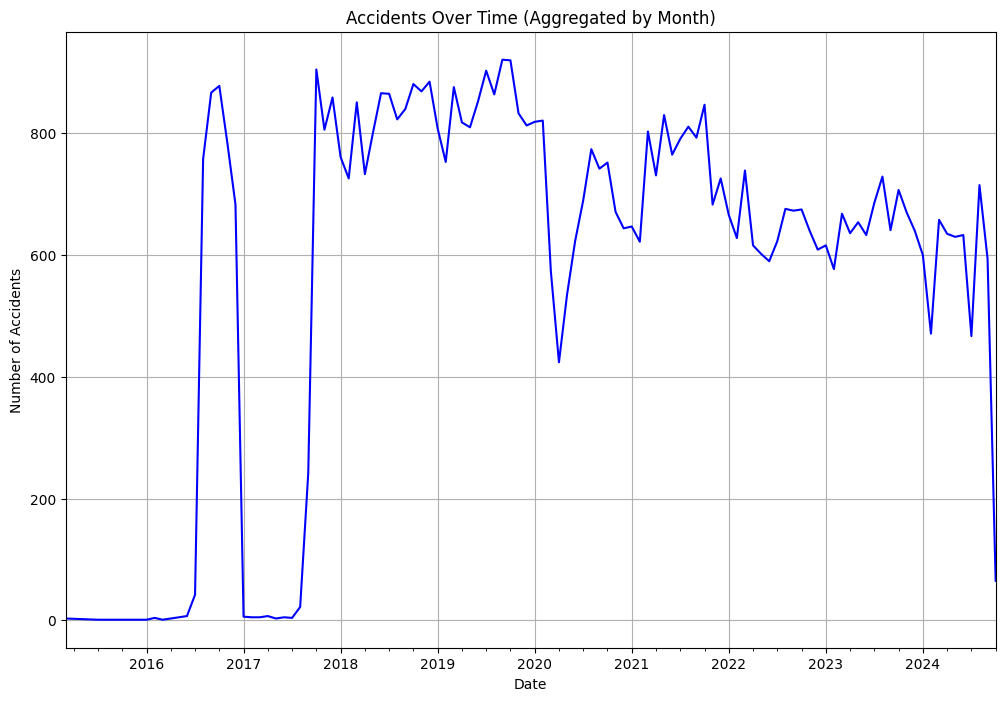

In [24]:
# Group by month
collisions['month'] = pd.to_datetime(collisions['date_time']).dt.to_period('M')
accidents_per_month = collisions.groupby('month').size()

plt.figure(figsize=(12, 8))
accidents_per_month.plot(kind='line', color='blue')
plt.title('Accidents Over Time (Aggregated by Month)')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()

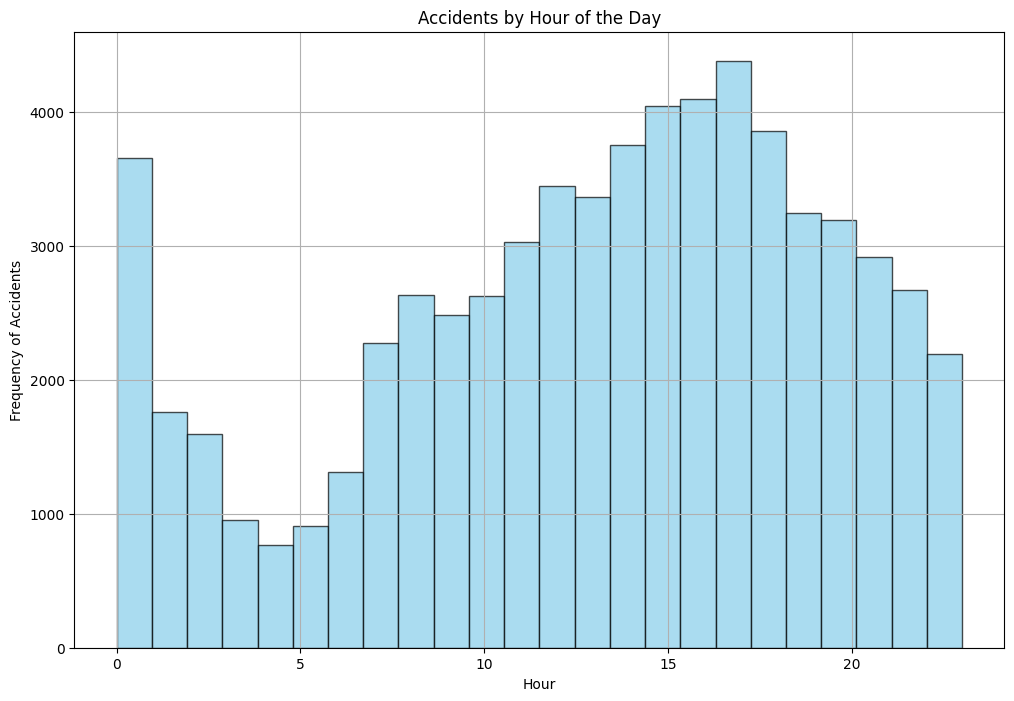

In [25]:
# Accident by time of the day
plt.figure(figsize=(12, 8))
collisions['hour'].plot(kind='hist', bins=24, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Frequency of Accidents')
plt.grid(True)
plt.show()

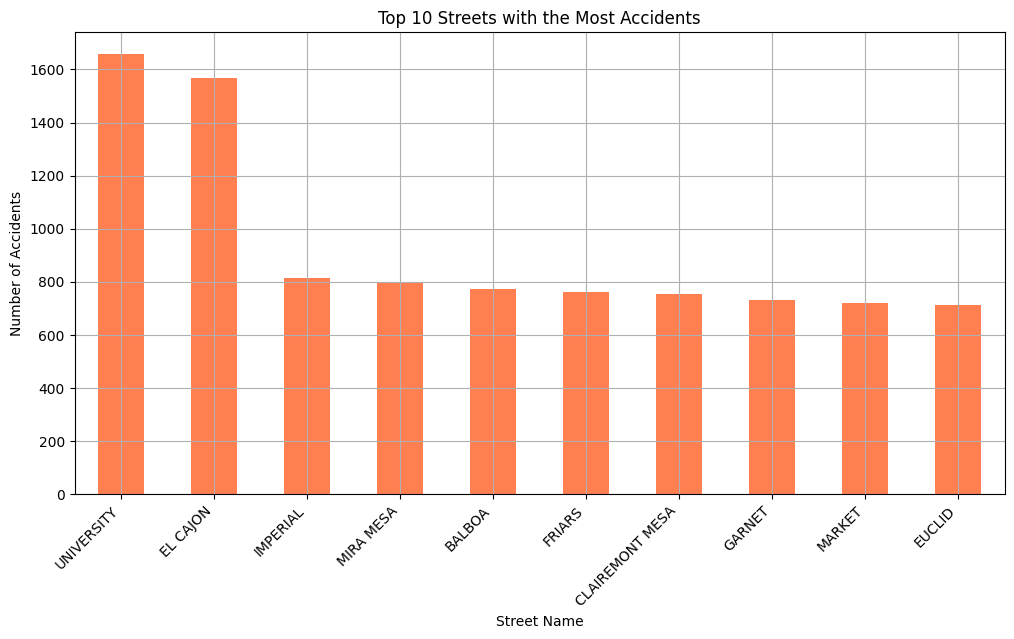

In [26]:
# Accidents by Roads and Intersections
top_roads = collisions['address_road_primary'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_roads.plot(kind='bar', color='coral')
plt.title('Top 10 Streets with the Most Accidents')
plt.xlabel('Street Name')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

### Injuries and Killed

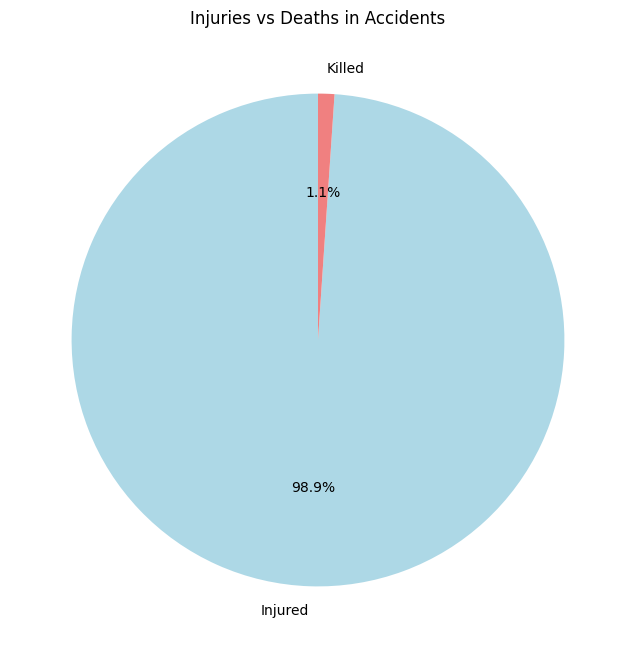

In [27]:
# Injuries vs killed in accidents
injuries_total = collisions['injured'].sum()
deaths_total = collisions['killed'].sum()
injuries_vs_deaths = [injuries_total, deaths_total]

fig, ax = plt.subplots(figsize=(8, 8), facecolor='white') 
ax.set_facecolor('white') 
ax.pie(injuries_vs_deaths, labels=['Injured', 'Killed'], autopct='%1.1f%%', 
       colors=['lightblue', 'lightcoral'], startangle=90, textprops={'color':'black'})
ax.set_title('Injuries vs Deaths in Accidents', color='black')
plt.show()

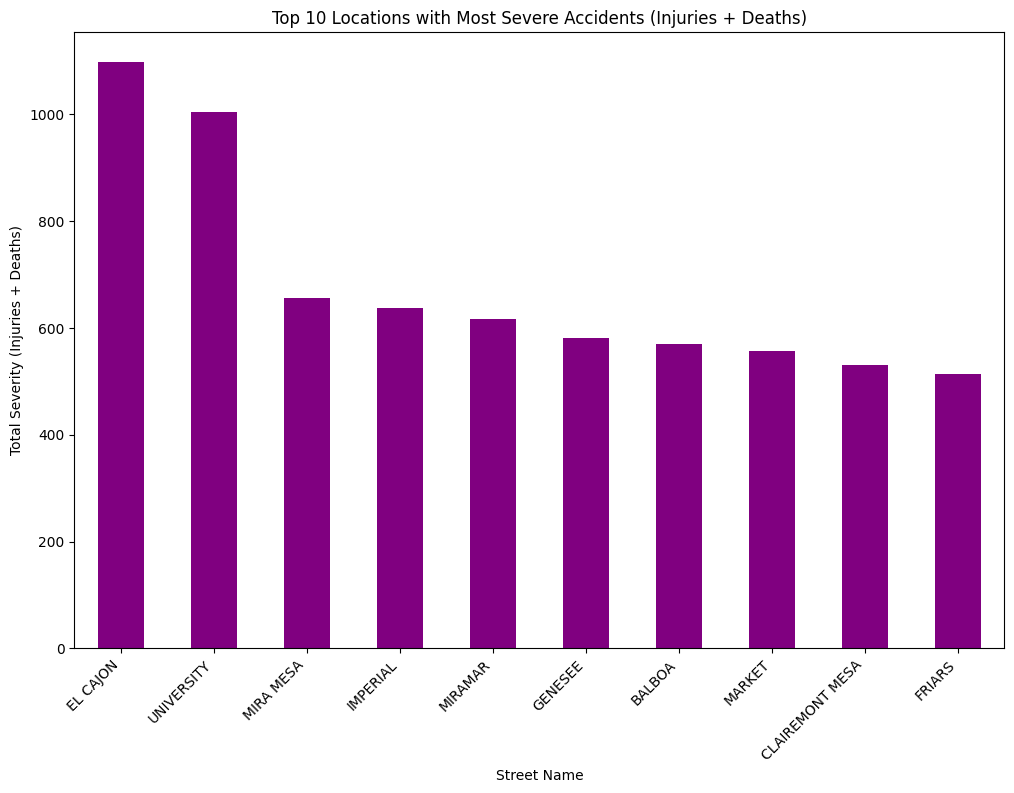

In [28]:
# Where do most severe accidents occur?
collisions['severity'] = collisions['injured'] + collisions['killed']
top_severe_locations = collisions.groupby('address_road_primary')['severity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
top_severe_locations.plot(kind='bar', color='purple')
plt.title('Top 10 Locations with Most Severe Accidents (Injuries + Deaths)')
plt.xlabel('Street Name')
plt.ylabel('Total Severity (Injuries + Deaths)')
plt.xticks(rotation=45, ha='right')
plt.show()

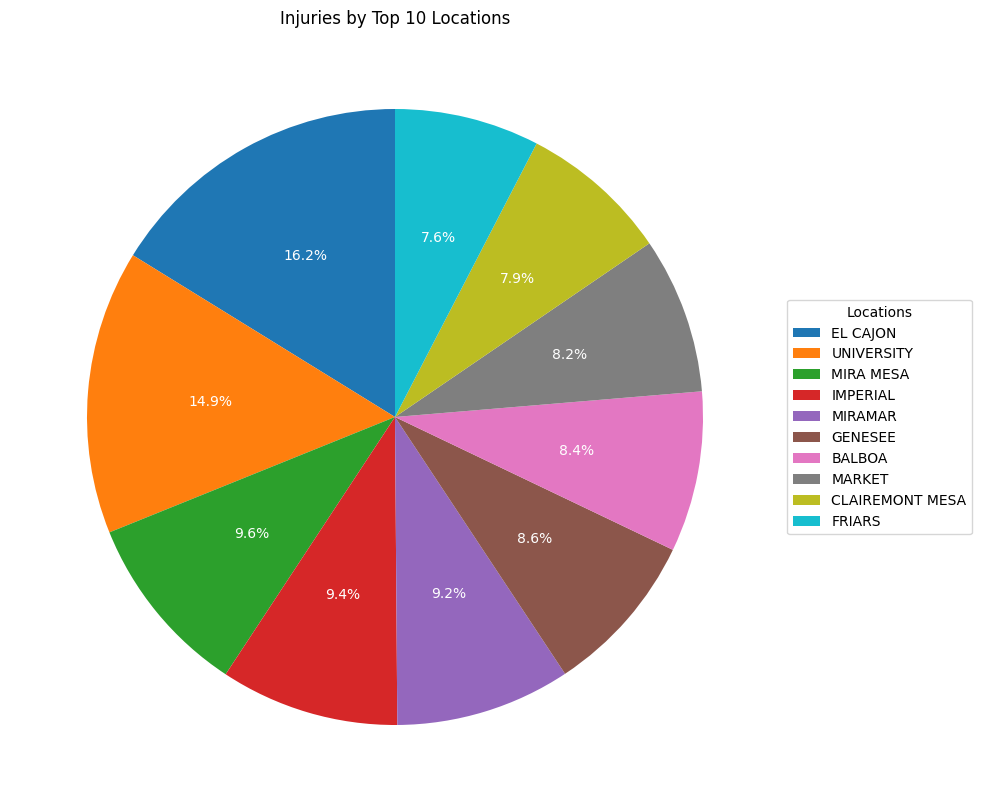

In [29]:
# Injuries and Fatatilities by Location
injuries_by_location = collisions.groupby('address_road_primary')['injured'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')  
ax.set_facecolor('white')  
wedges, texts, autotexts = ax.pie(injuries_by_location, autopct='%1.1f%%', startangle=90, textprops={'color': 'white'})
ax.legend(wedges, injuries_by_location.index, title="Locations", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Injuries by Top 10 Locations', color='black')
plt.show()

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_9690/3464488088.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  violations_injuries_deaths = collisions.groupby('violation_type')[['injured', 'killed']].sum()


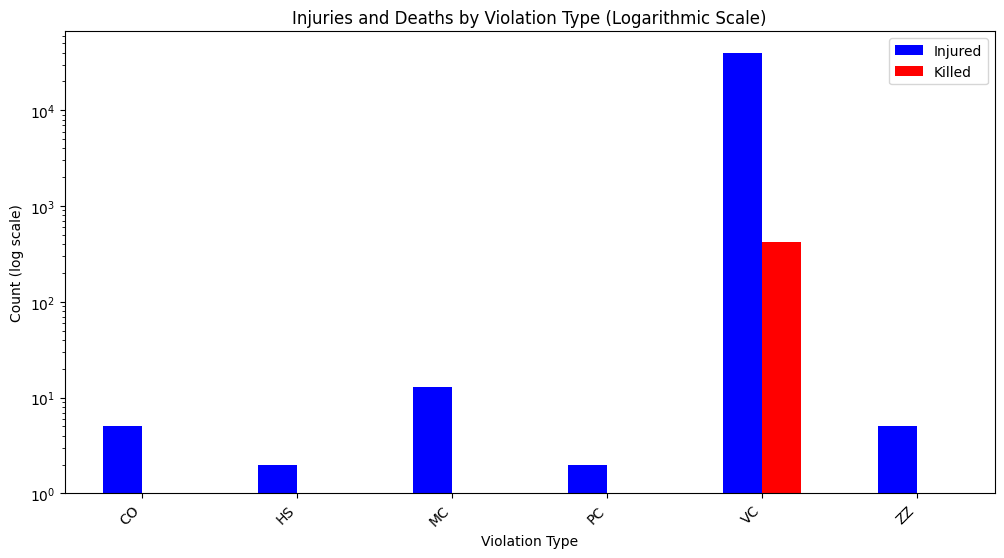

In [30]:
# Injuries and Fatatilities by Violation Types
violations_injuries_deaths = collisions.groupby('violation_type')[['injured', 'killed']].sum()

violations_injuries_deaths.plot(kind='bar', figsize=(12, 6), color=['blue', 'red'], log=True)
plt.title('Injuries and Deaths by Violation Type (Logarithmic Scale)')
plt.xlabel('Violation Type')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45, ha='right')
plt.legend(['Injured', 'Killed'])
plt.show()

### Time-based

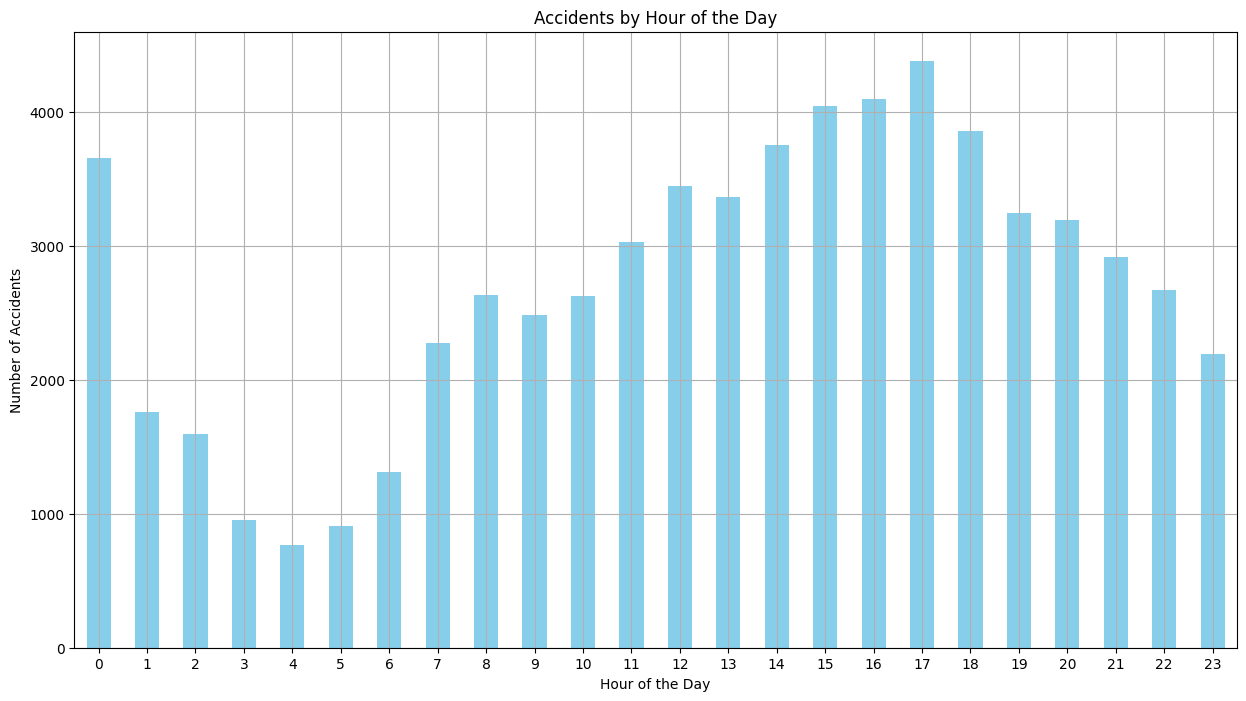

In [31]:
# Group by hour and count the number of accidents
accidents_by_hour = collisions.groupby('hour').size()

plt.figure(figsize=(15, 8))
accidents_by_hour.plot(kind='bar', color='skyblue')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

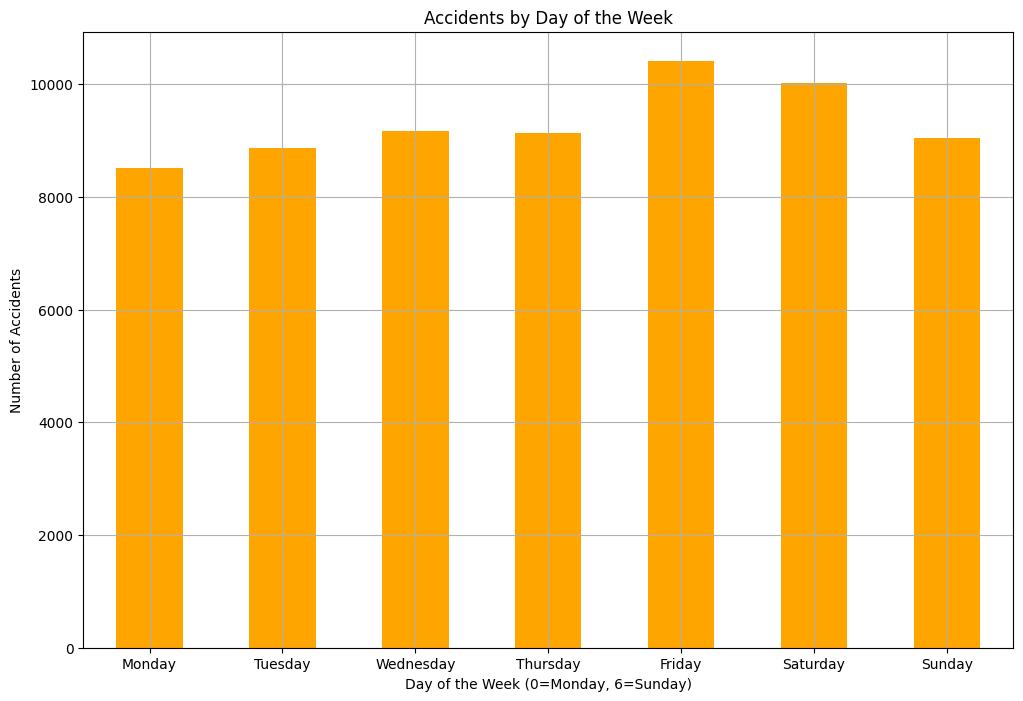

In [32]:
# Accidents by Day of the Week
collisions['day_of_week'] = pd.to_datetime(collisions['date_time']).dt.dayofweek
accidents_by_day = collisions.groupby('day_of_week').size()

plt.figure(figsize=(12, 8))
accidents_by_day.plot(kind='bar', color='orange')
plt.title('Accidents by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.grid(True)
plt.show()

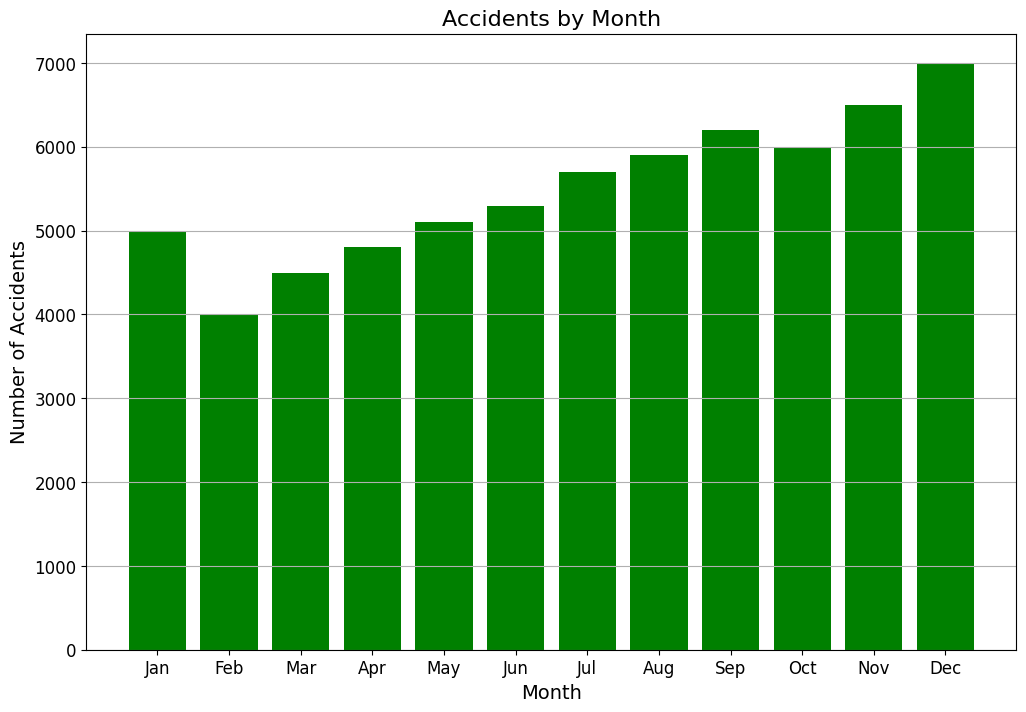

In [33]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Replace this with your actual accident counts
accidents_by_month = [5000, 4000, 4500, 4800, 5100, 5300, 5700, 5900, 6200, 6000, 6500, 7000]  # example data

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
ax.set_facecolor('white')
ax.bar(months, accidents_by_month, color='green')  
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Number of Accidents', fontsize=14)
ax.set_title('Accidents by Month', fontsize=16)
plt.grid(axis='y')  # Add gridlines for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the chart
plt.show()

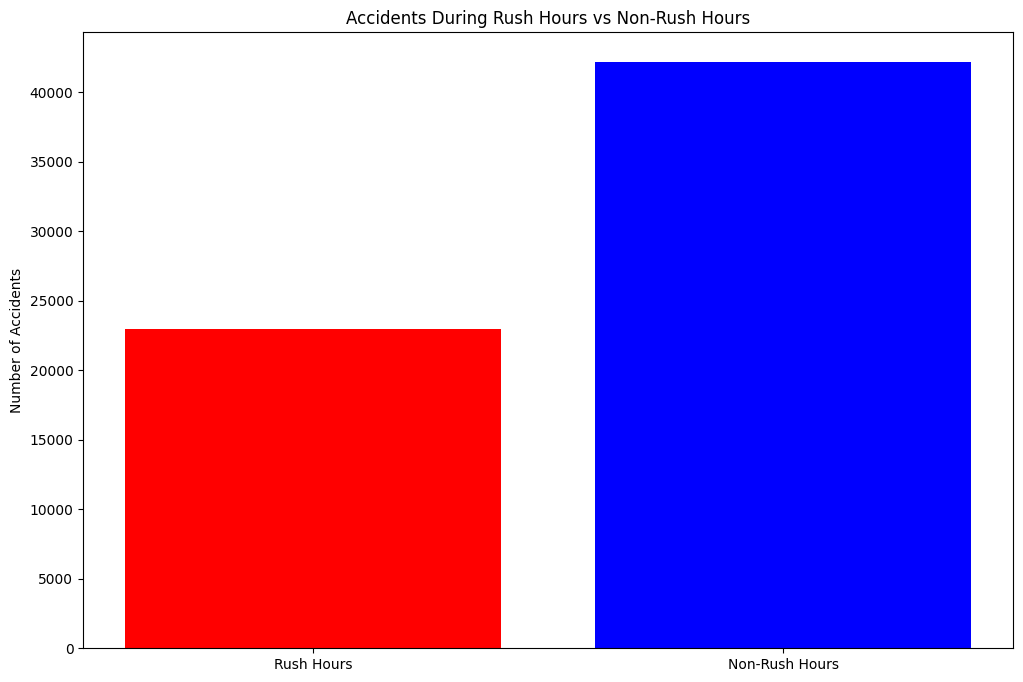

In [34]:
# Rush hour vs. non-rush hour accidents
# Define rush hour periods (7-9 AM, 4-7 PM)
rush_hours = (collisions['hour'].between(7, 9)) | (collisions['hour'].between(16, 19))
rush_hour_accidents = collisions[rush_hours].shape[0]
non_rush_hour_accidents = collisions[~rush_hours].shape[0]

plt.figure(figsize=(12, 8))
plt.bar(['Rush Hours', 'Non-Rush Hours'], [rush_hour_accidents, non_rush_hour_accidents], color=['red', 'blue'])
plt.title('Accidents During Rush Hours vs Non-Rush Hours')
plt.ylabel('Number of Accidents')
plt.show()

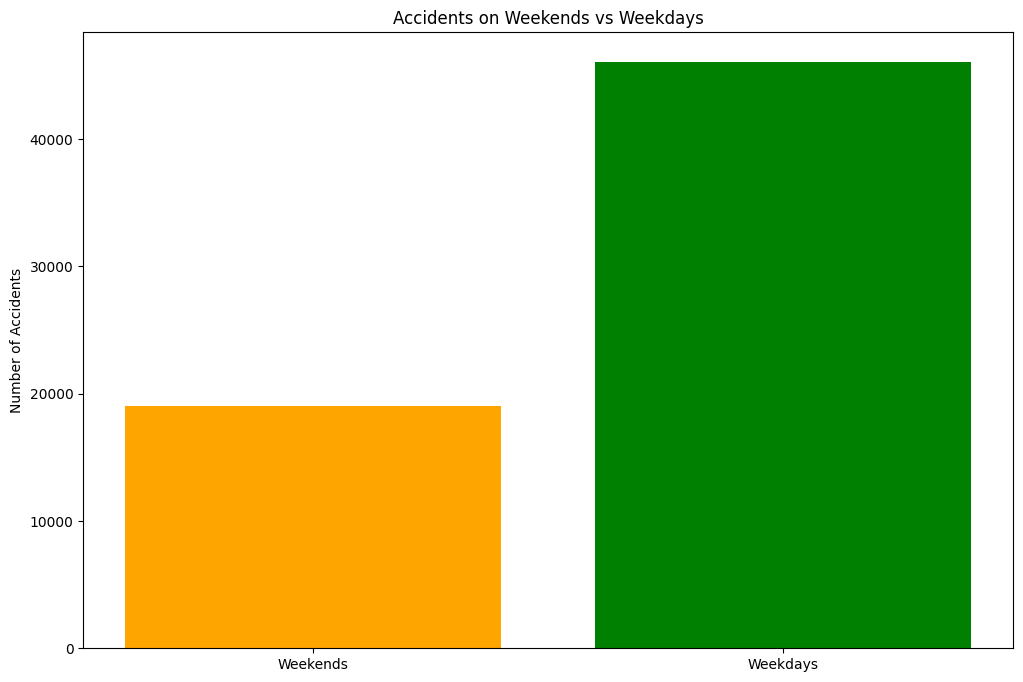

In [35]:
# Weekend vs. weekday accidents(Saturday=5, Sunday=6)
collisions['is_weekend'] = collisions['day_of_week'].isin([5, 6])
weekend_accidents = collisions[collisions['is_weekend']].shape[0]
weekday_accidents = collisions[~collisions['is_weekend']].shape[0]

plt.figure(figsize=(12, 8))
plt.bar(['Weekends', 'Weekdays'], [weekend_accidents, weekday_accidents], color=['orange', 'green'])
plt.title('Accidents on Weekends vs Weekdays')
plt.ylabel('Number of Accidents')
plt.show()

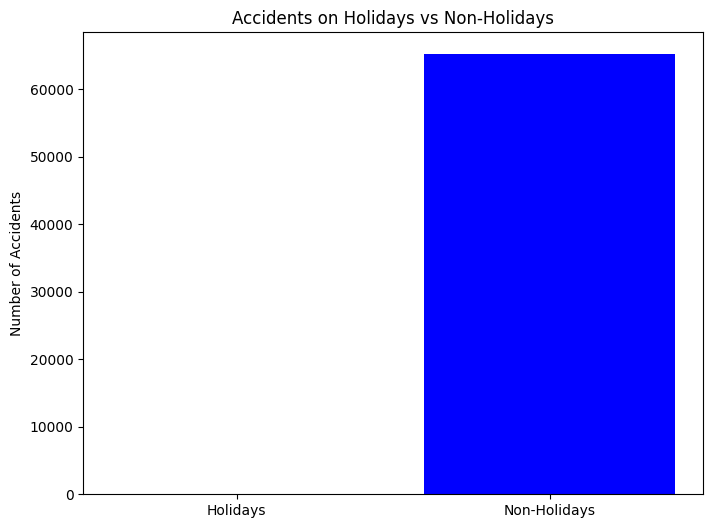

In [36]:
# holiday vs non-holiday accidents
holidays = calendar().holidays(start=collisions['date_time'].min(), end=collisions['date_time'].max())
collisions['is_holiday'] = collisions['date_time'].dt.date.isin(holidays)
holiday_accidents = collisions[collisions['is_holiday']].shape[0]
non_holiday_accidents = collisions[~collisions['is_holiday']].shape[0]

plt.figure(figsize=(8, 6))
plt.bar(['Holidays', 'Non-Holidays'], [holiday_accidents, non_holiday_accidents], color=['gold', 'blue'])
plt.title('Accidents on Holidays vs Non-Holidays')
plt.ylabel('Number of Accidents')
plt.show()

In [37]:
cal = calendar()
holidays = cal.holidays(start='2020-01-01', end='2023-12-31')
print(holidays)

DatetimeIndex(['2020-01-01', '2020-01-20', '2020-02-17', '2020-05-25',
               '2020-07-03', '2020-09-07', '2020-10-12', '2020-11-11',
               '2020-11-26', '2020-12-25', '2021-01-01', '2021-01-18',
               '2021-02-15', '2021-05-31', '2021-06-18', '2021-07-05',
               '2021-09-06', '2021-10-11', '2021-11-11', '2021-11-25',
               '2021-12-24', '2021-12-31', '2022-01-17', '2022-02-21',
               '2022-05-30', '2022-06-20', '2022-07-04', '2022-09-05',
               '2022-10-10', '2022-11-11', '2022-11-24', '2022-12-26',
               '2023-01-02', '2023-01-16', '2023-02-20', '2023-05-29',
               '2023-06-19', '2023-07-04', '2023-09-04', '2023-10-09',
               '2023-11-10', '2023-11-23', '2023-12-25'],
              dtype='datetime64[ns]', freq=None)


In [38]:
collisions['date'] = pd.to_datetime(collisions['date'])
holidays = pd.to_datetime(holidays)
collisions['is_holiday'] = collisions['date'].isin(holidays)
collisions['is_holiday'].value_counts()

is_holiday
False    64292
True       866
Name: count, dtype: int64

Average accidents per holiday: 20.14
Average accidents per non-holiday: 23.09


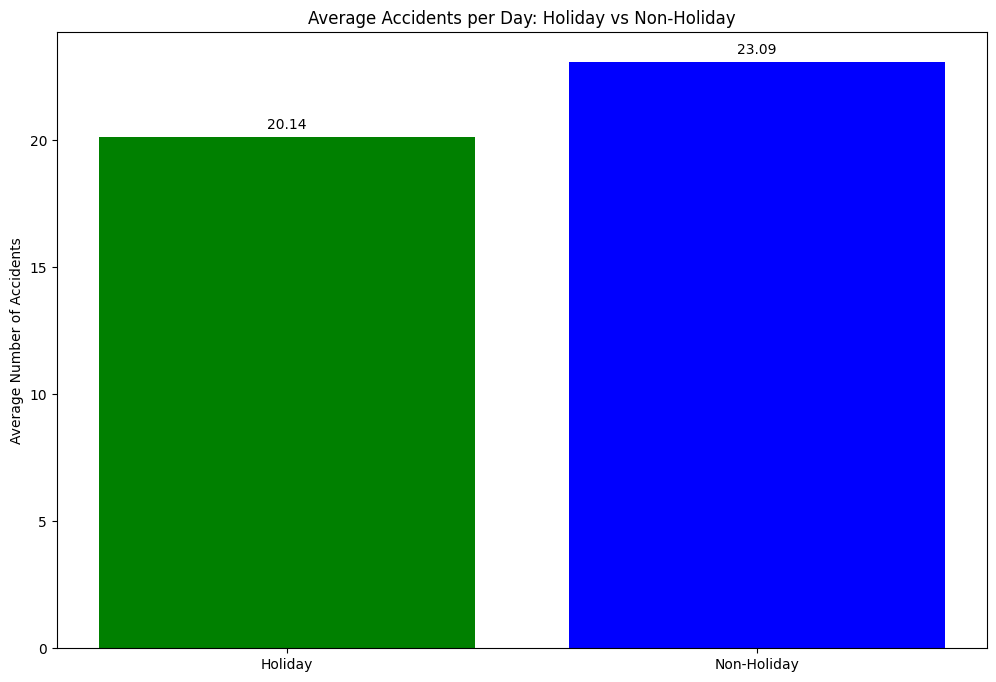

In [39]:

# Count the total number of accidents on holidays and non-holidays
total_holiday_accidents = collisions[collisions['is_holiday'] == True].shape[0]
total_non_holiday_accidents = collisions[collisions['is_holiday'] == False].shape[0]

# Calculate total days
total_days = collisions['date'].nunique()
total_holiday_days = len(holidays)
total_non_holiday_days = total_days - total_holiday_days

# Calculate and round the average accidents per holiday and non-holiday
if total_holiday_days > 0:  # Avoid division by zero
    average_holiday_accidents = round(total_holiday_accidents / total_holiday_days, 2)
else:
    average_holiday_accidents = 0

if total_non_holiday_days > 0:  # Avoid division by zero
    average_non_holiday_accidents = round(total_non_holiday_accidents / total_non_holiday_days, 2)
else:
    average_non_holiday_accidents = 0

print("Average accidents per holiday: " + str(average_holiday_accidents))
print("Average accidents per non-holiday: " + str(average_non_holiday_accidents))

# Prepare data for plotting
avg_accidents = [average_holiday_accidents, average_non_holiday_accidents]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(['Holiday', 'Non-Holiday'], avg_accidents, color=['green', 'blue'])
ax.bar_label(bars, labels=[f'{round(val, 2)}' for val in avg_accidents], padding=3)
ax.set_title('Average Accidents per Day: Holiday vs Non-Holiday')
ax.set_ylabel('Average Number of Accidents')
plt.show()


### Hotspots

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_9690/2314960124.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accidents_by_intersection = collisions.groupby(['address_road_primary', 'address_name_intersecting']).size().sort_values(ascending=False)


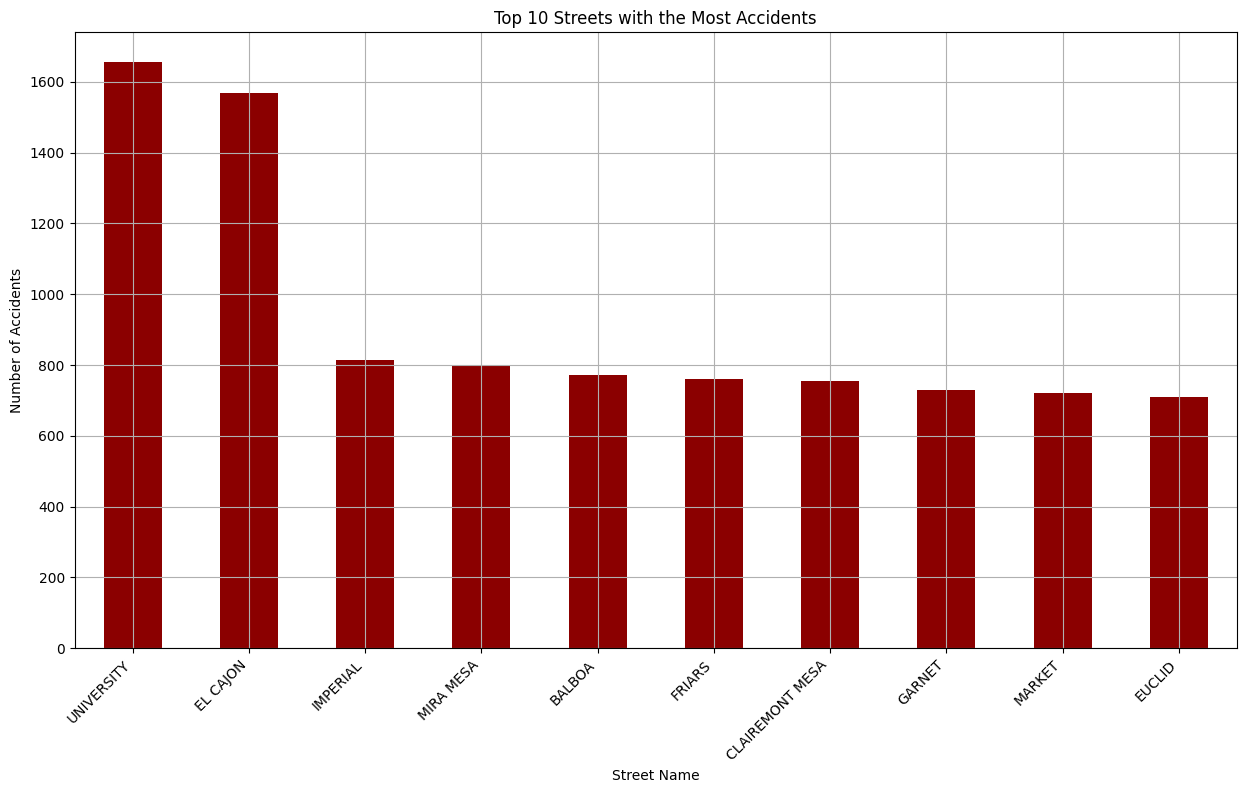

In [40]:
# Group by street 
accidents_by_street = collisions.groupby('address_road_primary').size().sort_values(ascending=False)
# Group by intersections
accidents_by_intersection = collisions.groupby(['address_road_primary', 'address_name_intersecting']).size().sort_values(ascending=False)

# Top 10 streets with the most accidents
top_streets = accidents_by_street.head(10)

plt.figure(figsize=(15, 8))
top_streets.plot(kind='bar', color='darkred')
plt.title('Top 10 Streets with the Most Accidents')
plt.xlabel('Street Name')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

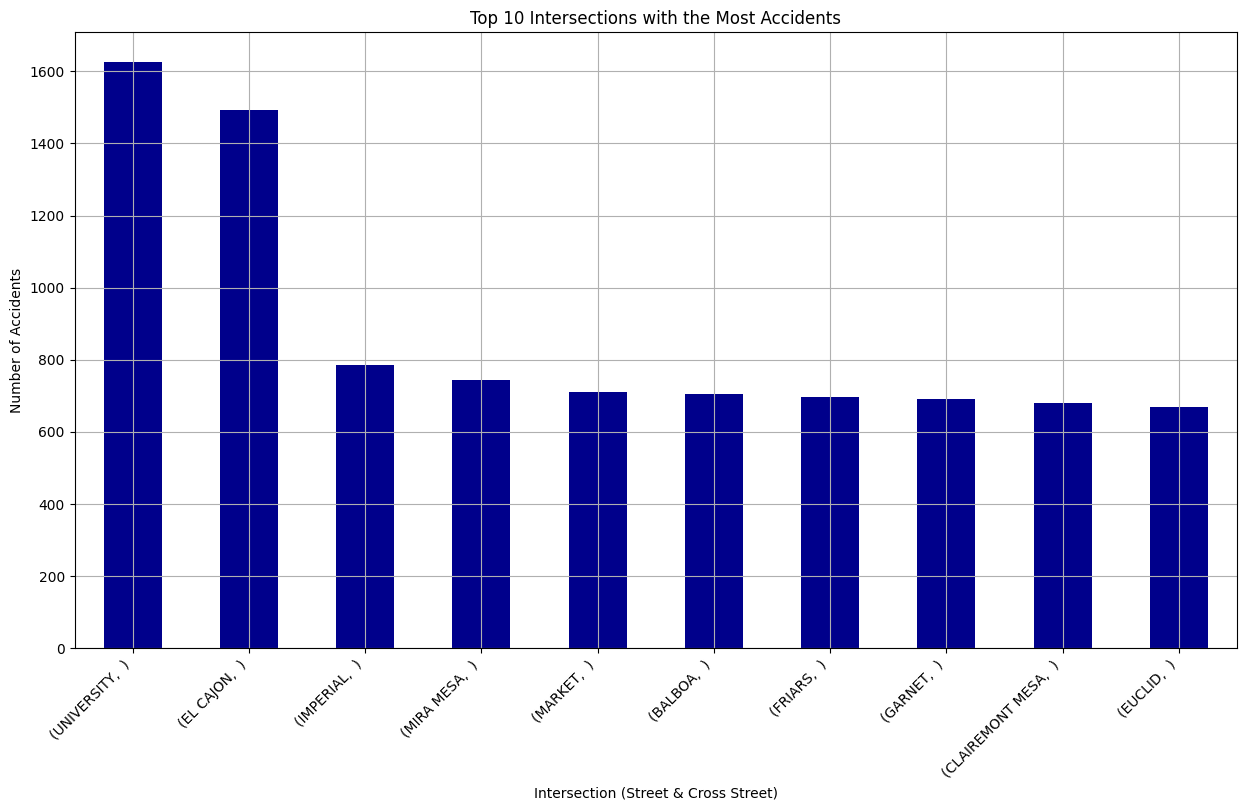

In [41]:
# Top 10 intersections with the most accidents
top_intersections = accidents_by_intersection.head(10)

plt.figure(figsize=(15, 8))
top_intersections.plot(kind='bar', color='darkblue')
plt.title('Top 10 Intersections with the Most Accidents')
plt.xlabel('Intersection (Street & Cross Street)')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Correlating Traffic Volume and Accident Data

In [42]:
# Ensure date columns are in datetime format
collisions['date'] = pd.to_datetime(collisions['date_time']).dt.date
traffic['date_count'] = pd.to_datetime(traffic['date_count']).dt.date

# Merge on the date column
df = pd.merge(collisions, traffic, left_on='date', right_on='date_count', how='inner')

In [43]:
accidents_by_road = df.groupby('address_road_primary').size()
traffic_volume_by_road = df.groupby('address_road_primary')['total_count'].sum()

# Merge accidents and traffic volume into one DataFrame
road_data = pd.DataFrame({
    'accidents': accidents_by_road,
    'traffic_volume': traffic_volume_by_road
})

road_data.head()

,accidents,traffic_volume
address_road_primary,,
01,1,11166
01-16-2020,2,29458
01ST,436,5357067
02ND,95,1176785
03RD,156,1943662


In [44]:
scaler = MinMaxScaler()

# Normalization
road_data[['accidents_normalized', 'traffic_volume_normalized']] = scaler.fit_transform(road_data[['accidents', 'traffic_volume']])

road_data.head()

,accidents,traffic_volume,accidents_normalized,traffic_volume_normalized
address_road_primary,,,,
01,1,11166,0.000000,0.000454
01-16-2020,2,29458,0.000496,0.001252
01ST,436,5357067,0.215667,0.233841
02ND,95,1176785,0.046604,0.051341
03RD,156,1943662,0.076847,0.084821


In [45]:
# Calculate the accident rate per unit of traffic volume (as risk factor)
road_data['risk_factor'] = road_data['accidents'] / road_data['traffic_volume']

# Replace infinity values with NaN
road_data['risk_factor'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
road_data[['accidents', 'traffic_volume', 'risk_factor']].head()

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_9690/299731582.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  road_data['risk_factor'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)


,accidents,traffic_volume,risk_factor
address_road_primary,,,
01,1,11166,0.000090
01-16-2020,2,29458,0.000068
01ST,436,5357067,0.000081
02ND,95,1176785,0.000081
03RD,156,1943662,0.000080


In [46]:
# Sort the data by risk factor
high_risk_roads = road_data.sort_values(by='risk_factor', ascending=False)

# Top 10 high-risk roads
high_risk_roads.head(10)

,accidents,traffic_volume,accidents_normalized,traffic_volume_normalized,risk_factor
address_road_primary,,,,,
TRINIDAD,1,775,0.000000,0.000000,0.001290
3OTH,1,895,0.000000,0.000005,0.001117
OLIVEWOOD,1,895,0.000000,0.000005,0.001117
BENFIELD,1,895,0.000000,0.000005,0.001117
WALKING PATH,1,1028,0.000000,0.000011,0.000973
THELBORN,1,1028,0.000000,0.000011,0.000973
CHARING,1,1210,0.000000,0.000019,0.000826
CAMINO SAN FERMIN,1,1277,0.000000,0.000022,0.000783
COLEMAN,2,2932,0.000496,0.000094,0.000682


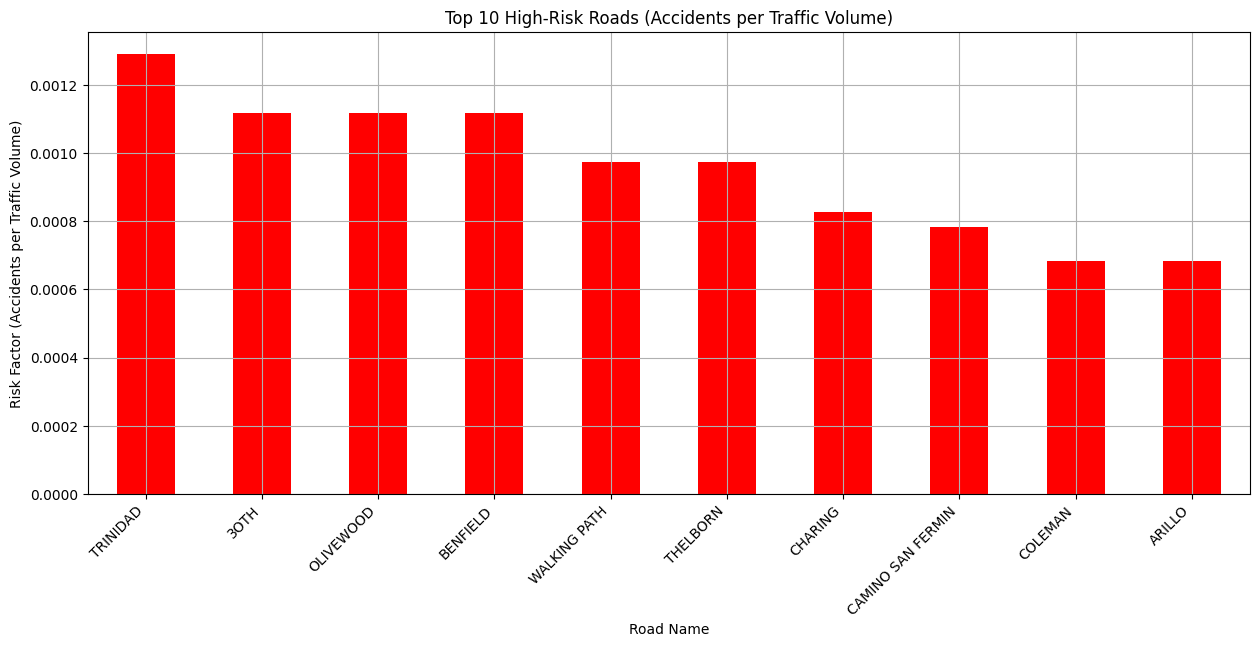

In [47]:
# Top 10 high-risk roads
plt.figure(figsize=(15, 6))
high_risk_roads['risk_factor'].head(10).plot(kind='bar', color='red')
plt.title('Top 10 High-Risk Roads (Accidents per Traffic Volume)')
plt.xlabel('Road Name')
plt.ylabel('Risk Factor (Accidents per Traffic Volume)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_9690/1622157854.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby('volume_bins')['num_accidents'].mean().reset_index()


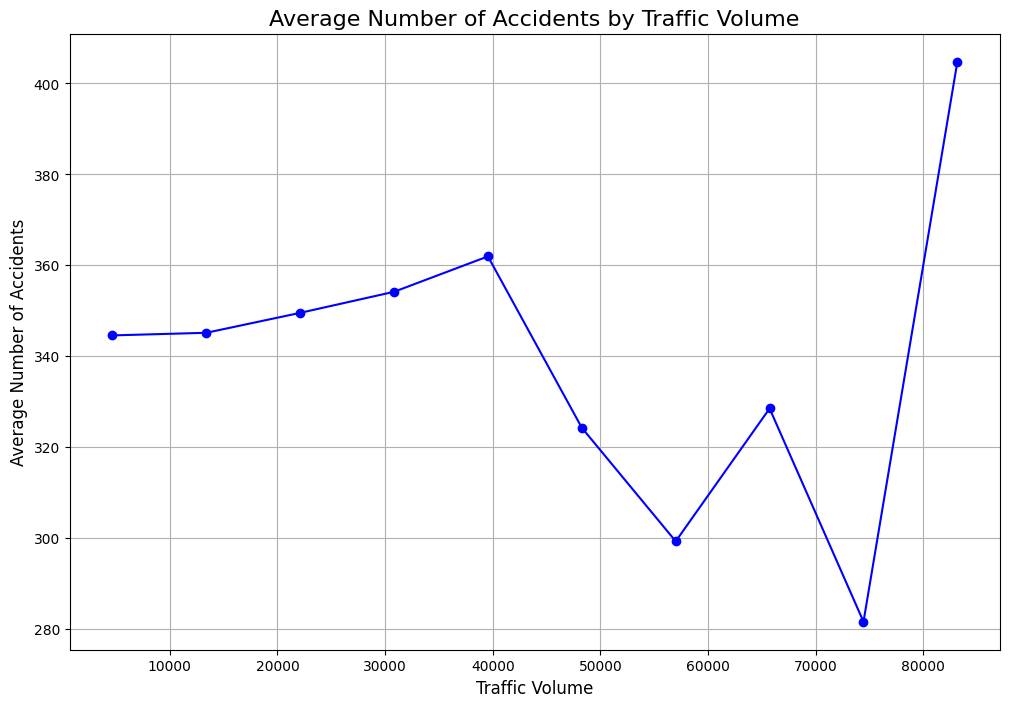

In [48]:
df['num_accidents'] = df.groupby('address_road_primary')['report_id'].transform('count')
df['volume_bins'] = pd.cut(df['total_count'], bins=10)
binned_data = df.groupby('volume_bins')['num_accidents'].mean().reset_index()
binned_data['bin_midpoints'] = binned_data['volume_bins'].apply(lambda x: x.mid)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(binned_data['bin_midpoints'], binned_data['num_accidents'], color='blue', marker='o')
ax.set_title('Average Number of Accidents by Traffic Volume', fontsize=16)
ax.set_xlabel('Traffic Volume', fontsize=12)
ax.set_ylabel('Average Number of Accidents', fontsize=12)
plt.grid(True)
plt.show()

# Predictive Modeling: Identify Future Hotspots

### Feature Engineering

### Modeling

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load your DataFrame
# df = pd.read_csv('your_file.csv')  # Ensure you load your DataFrame

# Step 1: Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Step 2: Handle Missing Values
# Example: Fill NaNs with mean/median/mode or using forward fill
# For numerical columns, fill NaNs with the mean
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# For categorical columns, fill NaNs with the mode
categorical_cols = df.select_dtypes(include=['category']).columns.tolist()
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Prepare Feature Set
# Define the target variable
y = df['severity']  # Assuming 'severity' is the target variable

# Drop unnecessary columns and create feature set
X = df.drop(columns=['report_id', 'date_time', 'severity', 'full_address', 'charge_desc'])

# Convert categorical columns to codes
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()
X[categorical_cols] = X[categorical_cols].apply(lambda x: x.cat.codes)

# Convert all columns to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Check for any remaining NaN values after conversion
print("Missing values after converting to numeric:")
print(X.isnull().sum())  # Check for remaining NaNs

# Step 6: Drop any remaining rows with NaN values
X = X.fillna(0)  # Alternatively, handle remaining NaNs appropriately

# Ensure there are enough samples
if X.shape[0] == 0 or y.shape[0] == 0:
    print("No samples left for training. Please check your data processing steps.")
else:
    # Step 7: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 8: Model Training
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Step 9: Evaluation
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_9690/846094938.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Missing values before cleaning:
report_id                    0
date_time                    0
police_beat                  0
address_no_primary           0
address_pd_primary           0
address_road_primary         0
address_sfx_primary          0
address_name_intersecting    0
address_sfx_intersecting     0
violation_section            0
violation_type               0
charge_desc                  0
injured                      0
killed                       0
hit_run_lvl                  0
date                         0
time                         0
day                          0
hour                         0
month                        0
season                       0
full_address                 0
severity                     0
day_of_week                  0
is_weekend                   0
is_holiday                   0
id                           0
street_name                  0
limits                       0
northbound_count             0
southbound_count             0
eastbou

In [50]:
print(y.value_counts())


severity
0    41022
1    28367
2     6449
3     1595
4      445
5      121
8       14
6        9
7        3
Name: count, dtype: int64


In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")


/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.98987504 0.98827299 0.99166934 0.9878885  0.98949055]
Mean cross-validation score: 0.98943928228132


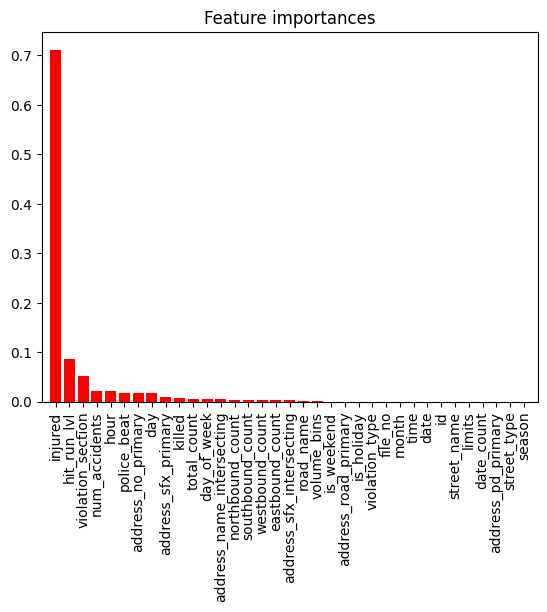

In [52]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [53]:
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Define a threshold for dropping features
threshold = 0.01

# Get features to drop
features_to_drop = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature']

# Drop these features from X
X_dropped = X.drop(columns=features_to_drop)


In [54]:
# Split the modified feature set
X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

# Fit the Random Forest model again
model_dropped = RandomForestClassifier(random_state=42)
model_dropped.fit(X_train_dropped, y_train)

# Evaluate the new model
y_pred_dropped = model_dropped.predict(X_test_dropped)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dropped))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8210
           1       1.00      1.00      1.00      5728
           2       1.00      1.00      1.00      1238
           3       1.00      1.00      1.00       316
           4       0.99      1.00      0.99        86
           5       1.00      0.95      0.97        20
           6       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         4

    accuracy                           1.00     15605
   macro avg       1.00      0.95      0.97     15605
weighted avg       1.00      1.00      1.00     15605



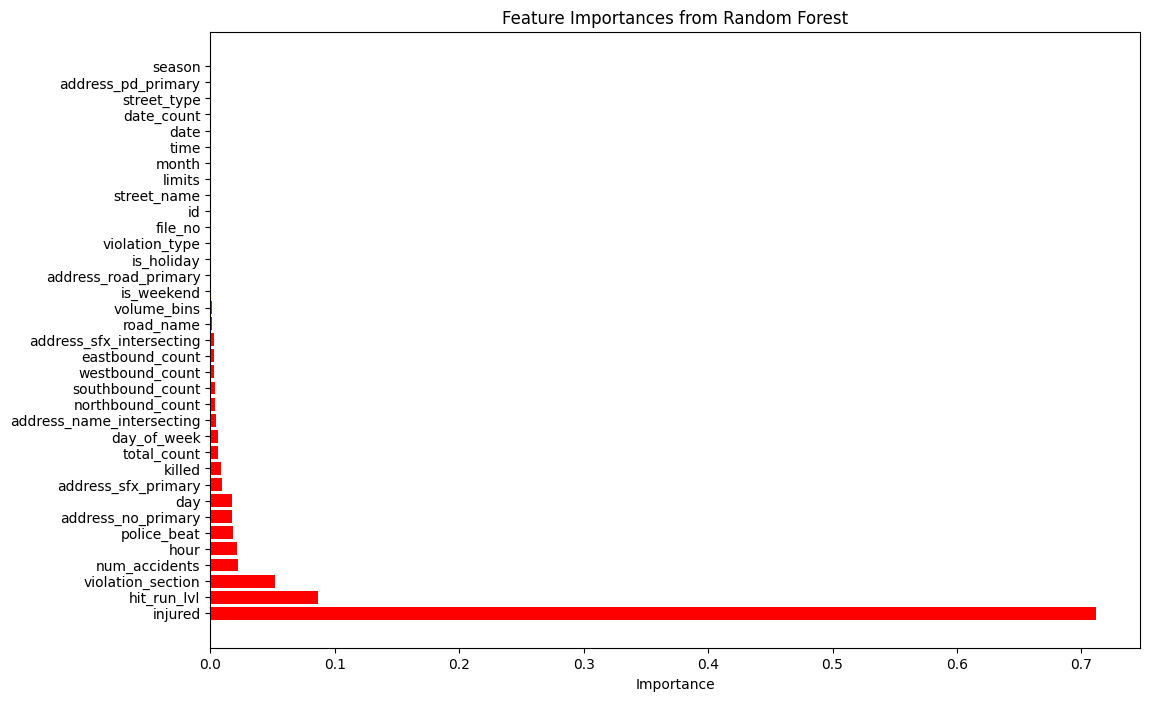

In [55]:
# Plotting Feature Importances
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Random Forest model
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for the feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='red')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()


In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC  # Import SVC here
from sklearn.metrics import classification_report, confusion_matrix

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Results for {model_name}:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("\n" + "="*50 + "\n")



Results for Random Forest:
[[8210    0    0    0    0    0    0    0]
 [   0 5728    0    0    0    0    0    0]
 [   0    0 1238    0    0    0    0    0]
 [   0    0    4  312    0    0    0    0]
 [   0    0    2    3   81    0    0    0]
 [   0    0    0    1    0   19    0    0]
 [   0    0    1    0    0    0    2    0]
 [   0    0    0    0    0    0    0    4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8210
           1       1.00      1.00      1.00      5728
           2       0.99      1.00      1.00      1238
           3       0.99      0.99      0.99       316
           4       1.00      0.94      0.97        86
           5       1.00      0.95      0.97        20
           6       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         4

    accuracy                           1.00     15605
   macro avg       1.00      0.94      0.97     15605
weighted avg       1.00      1.0

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'severity' is your target variable
class_counts = df['severity'].value_counts()
print(class_counts)
majority_class = class_counts.max()
minority_class = class_counts.min()
imbalance_ratio = majority_class / minority_class
print(f'Imbalance Ratio: {imbalance_ratio:.2f}')


severity
0    41022
1    28367
2     6449
3     1595
4      445
5      121
8       14
6        9
7        3
Name: count, dtype: int64
Imbalance Ratio: 13674.00


In [59]:
!pip install imblearn

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [60]:
from imblearn.over_sampling import SMOTE
class_counts = y_train.value_counts()
print("Class distribution before SMOTE:")
print(class_counts)

# Step 3: Apply SMOTE with a lower k_neighbors parameter if necessary
smote = SMOTE(random_state=42, k_neighbors=1)  # Set k_neighbors to 1 or another low number
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Step 4: Train the model using the resampled data
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Class distribution before SMOTE:
severity
0    32812
1    22639
2     5211
3     1279
4      359
5      101
8       10
6        6
7        3
Name: count, dtype: int64
Class distribution after SMOTE:
severity
5    32812
1    32812
0    32812
2    32812
3    32812
4    32812
8    32812
6    32812
7    32812
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8210
           1       1.00      1.00      1.00      5728
           2       1.00      1.00      1.00      1238
           3       0.99      1.00      0.99       316
           4       0.99      0.98      0.98        86
           5       1.00      0.95      0.97        20
           6       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         4

    accuracy                           1.00     15605
   macro avg       1.00      0.95      0.97     15605
weighted avg       1.00      1.00      1.00     15605



In [61]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1_macro', cv=3)
grid_search.fit(X_resampled, y_resampled)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score:  0.9989699128510198


In [62]:
model = RandomForestClassifier(random_state=42)

# Step 3: Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Step 4: Analyze the results
print("Cross-validation scores: ", cv_scores)
print(f"Mean cross-validation score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores:  [0.99959949 0.99983979 0.99967959 0.99927908 0.9999199 ]
Mean cross-validation score: 0.9997 ± 0.0002
